# Assignment 3
# Part 1: Segmentation

## Problem 5
### Implement interactive seed-based segmentation using s/t graph cut algorithm.
#### A basic seed-interactive GUI "GraphCutsPresenter" is available (implemented in "asg1.py"). The starter code below uses it. Presenter allows to add seeds (left and right mouse clicks for object and background seeds) and displays these seeds over the image. However, instead of proper graph cut segmentation the provided code displays some fixed binary mask (just as an example of a mask). This "fixed" mask should be replaced by the output of an interactive image segmentation method based on minimum s/t graph cut respecting the hard constraints marked by the user-seeds. You can use an existing library for computing minimum s/t cuts on arbitrary graphs (e.g. install <a href="http://www.cs.uwaterloo.ca/~yboykov/Courses/cs484/python_lib/PyMaxflow-1.2.4.win-amd64-py2.7.exe">PyMaxflow 1.2.4</a>, see <a href="http://pmneila.github.io/PyMaxflow/maxflow.html">documentation</a>). You can use this library to build a weighted graph based on selected image and user-entered seeds.
#### As a first milestone, you should implement graph cut segmentation using only hard-constraints (from seeds) and "contrast-weights" $w_{pq}\propto \exp\frac{-\|I_p-I_q\|^2}{\sigma^2}$ for neighborhood edges or "n-links", as suggested in Topic 9. Terminal "t-links" for seed-points should make sure that such graph nodes can not be severed from the corresponding terminals. You have to use "large-enough" finite cost t-links to enforce hard-constraints (user seeds) since "infinity" weight is not possible to implement. One can argue that $N\cdot \max \{w_{pq}\}$ (number of neighbors at each point times the largest n-link weight) is sufficient.
#### Once the first version above is implemented and tested, use seed pixels to compute color histograms $\Pr(I|1)$ and $\Pr(I|0)$ for two types of seeds. Computing histograms requires binning (quantization) of the color space that should be done via K-means over all image pixel colors (experiment with different bumber of bins K to see what works better in segmentation). Then, seed-pixels histograms $\Pr(I|1)$ and $\Pr(I|0)$ based on such bins should be used for unary potentials  $-\ln\Pr(I_p|1)$ and $-\ln\Pr(I_p|0)$ for all pixels $p$. Implement graph cut segmentation producing <font color=blue>seed-consistent</font> result $S$ minimizing the following objective (loss)
#### $$ E(S) = -\sum_p \ln\Pr(I_p|S_p) + \lambda \cdot \sum_{pq\in N} w_{pq} \cdot [S_p\neq S_q] . $$
#### Since seed-consistency is required, you should still enforce hard constraints on seeds.
#### NOTE 1: max-flow/min-cut libraries are typically more efficient when using integer edge weights in a relatively small range. You can use integer-weighted graph where edge weights are discretized/truncated values of your edge-weighting function.
#### NOTE 2: Test different values of "regularization parameter" $\lambda$ (scalar giving relative weight of the n-links vs t-links) as in the formula above.
#### NOTE 3: Play with parameter $\sigma$ for exponential n-link weighting function in $w_{pq}\propto \exp\frac{-\|I_p-I_q\|^2}{\sigma^2}$ using intensity differences/contrast between two pixels. Test different values of  $\sigma$. Show 2-3 representative results (in different cells). Use markdown cell to discuss your observations, if any. If you can suggest some specific way of selecting some $\sigma$ adaptively to each image, provide a brief technical motivation for it.
#### NOTE 4: You can use either 4 or 8 connected grid.

In [2]:
%matplotlib notebook

# loading standard modules
import numpy as np
import matplotlib.pyplot as plt
import maxflow
from skimage import img_as_ubyte
from skimage.color import rgb2grey
# loading custom module (requires file asg1.py in the same directory as the notebook file)
from asg1_error_handling import Figure, GraphCutsPresenter
import sys
from scipy.spatial import distance
from sklearn.cluster import KMeans


# First milestone:
(Here we assume red area is background and blue area is object)

In [3]:
class MyGraphCuts:
    bgr_value = 0
    obj_value = 1
    none_value = 2
    
    def __init__(self, img):
        self.fig = Figure()
        self.pres = GraphCutsPresenter(img, self)
        self.pres.connect_figure(self.fig)

        self.num_rows = img.shape[0]
        self.num_cols = img.shape[1]
        self.seedMask = np.zeros(shape=(img.shape[0],img.shape[1]))
              
    def run(self): 
        self.fig.show()
    
            
    def compute_labels(self, seed_mask):
        num_rows = self.num_rows
        num_cols = self.num_cols
        label_mask = np.full((num_rows, num_cols), self.none_value, dtype='uint8')

        g = maxflow.Graph[float]()
        nodeids = g.add_grid_nodes((num_rows, num_cols))

        weightsRight = np.zeros(shape=(num_rows, num_cols))
        weightsDown = np.zeros(shape=(num_rows, num_cols))
        image = self.pres.img
        row0,col0 = np.array(np.where(seed_mask==0)) # Seeded pixels are background
        row1,col1 = np.array(np.where(seed_mask==1)) # Seeded pixels are foreground
        
        ####### Sigma is the related to level of variation in the image
        ####### And it is set to the average absolute intensity difference between the neighboring pixels
        num_rows = image.shape[0]
        num_cols = image.shape[1]
        nodeids = g.add_grid_nodes((num_rows, num_cols))
        temp1 = np.zeros(shape=(num_rows* (num_cols-1) + (num_rows-1) * num_cols))
        temp2 = np.zeros(shape=((num_rows-1) * num_cols))
        eps = sys.float_info.epsilon
        j = 0
        for r in range(num_rows):
            for c in range (num_cols):
                if (c!=(num_cols-1)):
                    temp1[j] = np.abs(np.average(image[r,c])- np.average(image[r,c+1]))+eps
                    j+=1
                if (r!=(num_rows-1)):
                    temp1[j] = np.abs(np.average(image[r,c])- np.average(image[r+1,c]))+eps
                    j+=1
        variance = np.var(temp1, dtype=np.float64)
        maxWeight = 0
        for r in range (num_rows):
            for c in range(num_cols):
                if c < (num_cols-2): 
                    temp = distance.sqeuclidean(image[r,c],image[r,c+1])
                    weightsRight = np.exp(-temp/variance)
                    g.add_edge((r*num_cols)+c, (r*num_cols)+c+1, weightsRight, weightsRight)
                    if (weightsRight> maxWeight):
                        maxWeight = weightsRight
                if r < (num_rows-2):
                    temp = distance.sqeuclidean(image[r,c],image[r+1,c])
                    weightsDown =np.exp(-temp/variance)
                    g.add_edge((r*num_cols)+c, ((r+1)*num_cols)+c, weightsDown, weightsDown)
                    if (weightsDown > maxWeight):
                        maxWeight = weightsDown
                if seed_mask[r,c] == 0:
                    g.add_tedge((r*num_cols)+c, maxWeight*3, 0)
                if seed_mask[r,c] == 1:
                    g.add_tedge((r*num_cols)+c,0, maxWeight*3)
                
        g.maxflow()
        for r in range (self.num_rows-1):
            for c in range(self.num_cols-1):
                label_mask[r][c] = g.get_segment((r*num_cols)+c)
    
        return label_mask

   

### Notes about the basic graph cut interface:
1. To provide the regional hard constraints (seeds) for object and background segments use left and right mouse clicks (mouse dragging works somewhat too). Use mouse wheel to change the brush size.
2. The seed mask is built by the "GraphCutsPresenter". Each mouse release activates "on_mouse_up" function of the presenter, which asks the linked MyGraphCuts object to "compute_labels" for all pixels
based on the provided seed mask.
3. You should use "PyMaxflow" library (already imported into this notebook if you ran the second cell) to build a weighted graph and to compute a minimum s/t cut defining all pixel labels from the seeds as explain in topic 5.

<IPython.core.display.Javascript object>


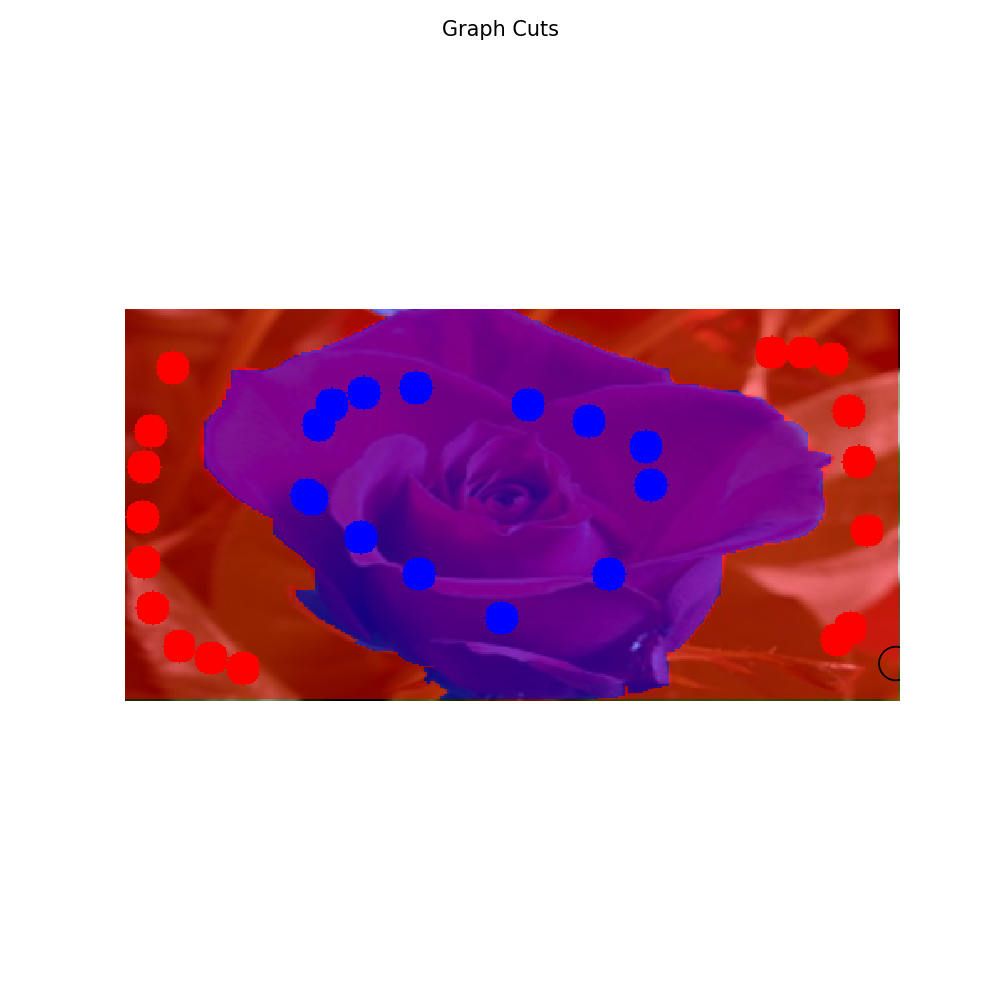

In [43]:
img = plt.imread('images/rose.bmp')
app = MyGraphCuts(img[10:300,:600])
app.run()


### Add two more cells loading images (can use yours) where your implementation of MyGraphCuts works OK.

<IPython.core.display.Javascript object>


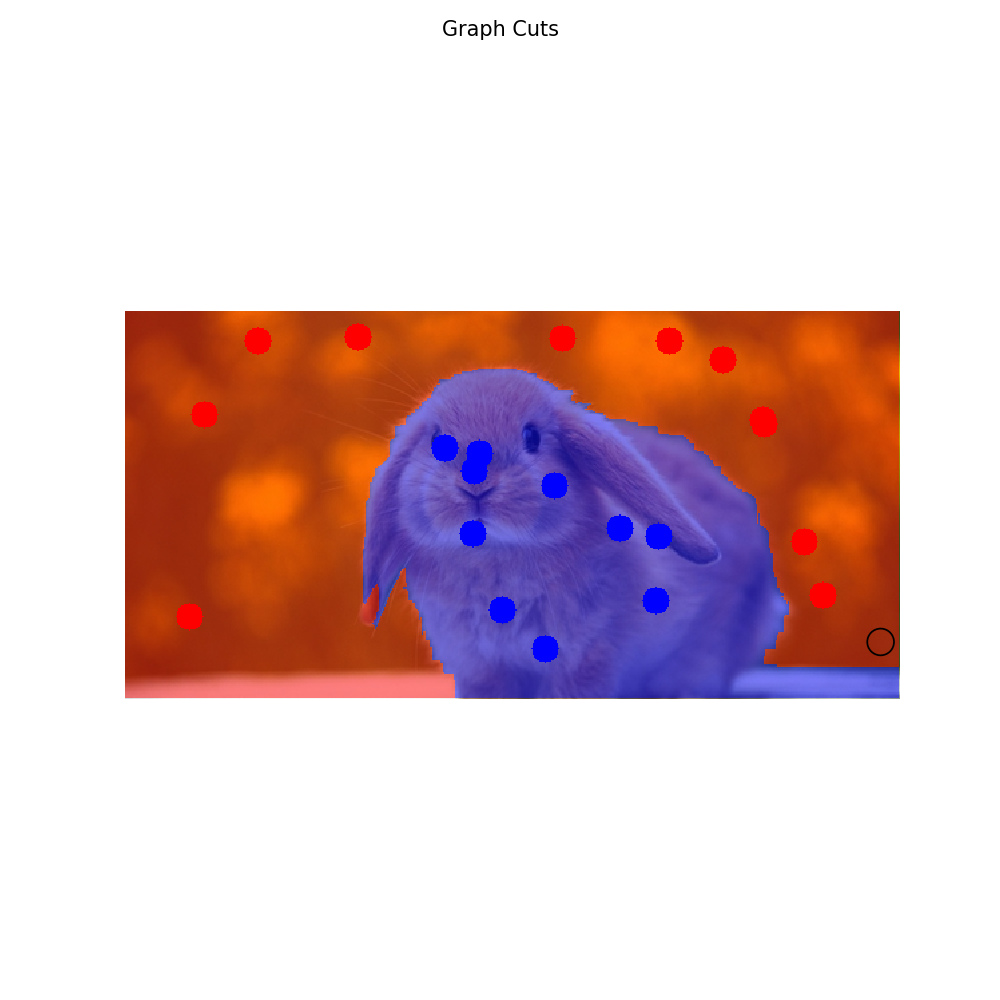

In [44]:
img = plt.imread('images/bunny.bmp')
app = MyGraphCuts(img[10:300,:600])
app.run()


<IPython.core.display.Javascript object>


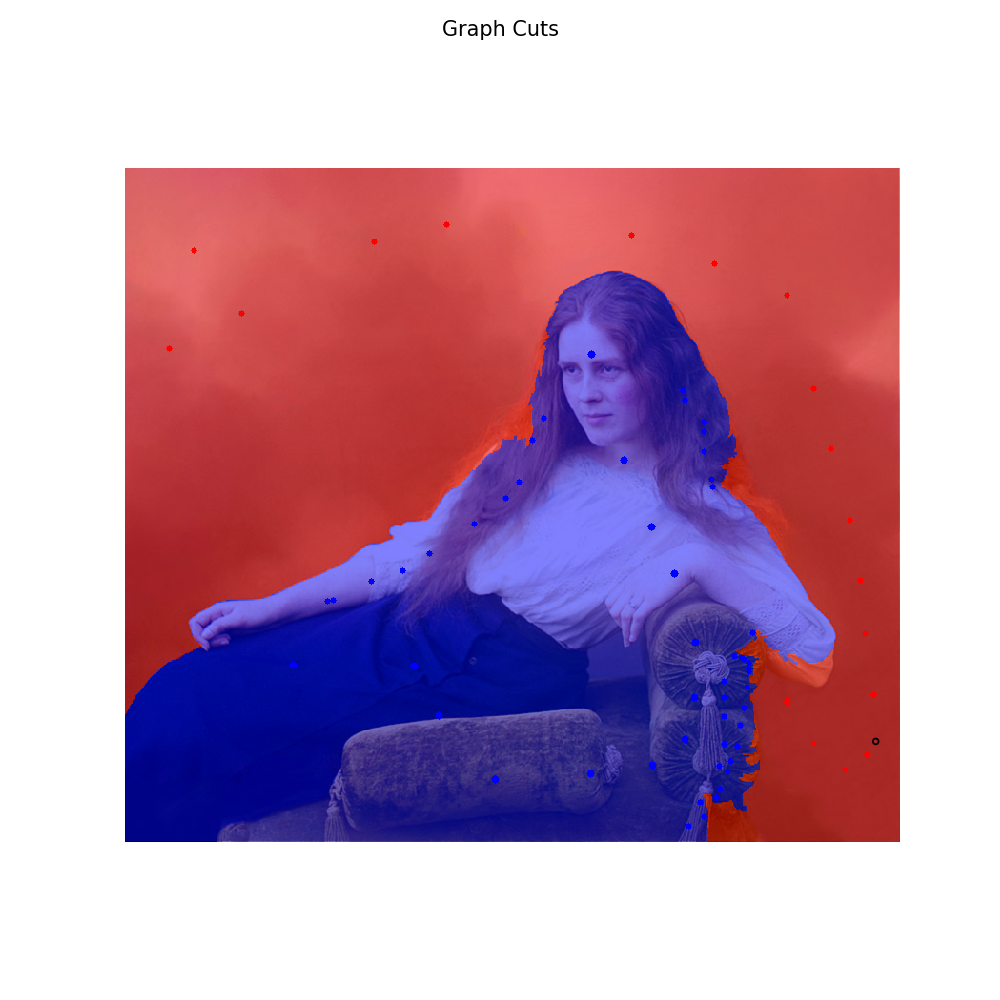

In [4]:
img = plt.imread('images/model.bmp')
app = MyGraphCuts(img)
app.run()


# Second milestone (using sklearn Kmeans):
(My GraphCuts implementation is such that there will be segmentation only after at least 1 background and 1 object seed have been plotted) (Here we assume red area is background and blue area is object)

In [5]:
from sklearn.cluster import KMeans
    
class MyGraphCuts:
    bgr_value = 0
    obj_value = 1
    none_value = 2
        
    def __init__(self, img):
        self.fig = Figure()
        self.pres = GraphCutsPresenter(img, self)
        self.pres.connect_figure(self.fig)

        self.num_rows = img.shape[0]
        self.num_cols = img.shape[1]

    def run(self): 
        self.fig.show()
    
            
    def compute_labels(self, seed_mask):
        num_rows = self.num_rows
        num_cols = self.num_cols
        image = self.pres.img
        
        label_mask = np.full((num_rows, num_cols), self.none_value, dtype='uint8')
        g = maxflow.Graph[float]()
        nodeids = g.add_grid_nodes((num_rows, num_cols))

        weightsRight = np.zeros(shape=(num_rows, num_cols))
        weightsDown = np.zeros(shape=(num_rows, num_cols))
        row0,col0 = np.array(np.where(seed_mask==0)) # Seeded pixels are background
        row1,col1 = np.array(np.where(seed_mask==1)) # Seeded pixels are foreground
        
        ## Sigma is the related to level of variation in the image
        ## And it is set to the average absolute intensity difference between the neighboring pixels
        num_rows = image.shape[0]
        num_cols = image.shape[1]
        nodeids = g.add_grid_nodes((num_rows, num_cols))
        weightsRight = np.zeros(shape=(num_rows, num_cols), dtype= np.float64)
        weightsDown = np.zeros(shape=(num_rows, num_cols), dtype=np.float64)
        temp1 = np.zeros(shape=(num_rows* (num_cols-1) + (num_rows-1) * num_cols))
        temp2 = np.zeros(shape=((num_rows-1) * num_cols))
        eps = sys.float_info.epsilon
        j = 0
        for r in range(num_rows):
            for c in range (num_cols):
                if (c!=(num_cols-1)):
                    temp1[j] = np.abs(np.average(image[r,c])- np.average(image[r,c+1]))+eps
                    j+=1
                if (r!=(num_rows-1)):
                    temp1[j] = np.abs(np.average(image[r,c])- np.average(image[r+1,c]))+eps
                    j+=1
        variance = np.var(temp1, dtype=np.float64)
        
        maxWeight = 0
        for r in range (num_rows):
            for c in range(num_cols):
                if c < (num_cols-2): 
                    temp = distance.sqeuclidean(image[r,c]/10,image[r,c+1]/10)
                    weightsRight = np.exp(-temp/variance)
                    g.add_edge((r*num_cols)+c, (r*num_cols)+c+1, weightsRight, weightsRight)
                    if (weightsRight> maxWeight):
                        maxWeight = weightsRight
                if r < (num_rows-2):
                    temp = distance.sqeuclidean(image[r,c]/10,image[r+1,c]/10)
                    weightsDown =np.exp(-temp/variance)
                    g.add_edge((r*num_cols)+c, ((r+1)*num_cols)+c, weightsDown, weightsDown)
                    if (weightsDown > maxWeight):
                        maxWeight = weightsDown
                if seed_mask[r,c] == 0:
                    g.add_tedge((r*num_cols)+c, maxWeight*3, 0)
                if seed_mask[r,c] == 1:
                    g.add_tedge((r*num_cols)+c,0, maxWeight*3)
                
        g.maxflow()

        seg = g.get_grid_segments(nodeids)
        
        #####################################################################################################################
        ### Colour Quantisation ###
        if (row0.size >0 and row1.size>0):
            # Load Image and transform to a 2D numpy array
            arrayRGB = image.reshape(num_rows*num_cols, 3)
            bins = 6
            kmeans = KMeans(n_clusters= bins, random_state = 0).fit(arrayRGB)
            colourSeg = kmeans.labels_
            colourSeg = colourSeg.reshape(num_rows,num_cols)
            Pr0 = np.zeros(shape = bins)
            Pr1 = np.zeros(shape = bins)
            for seg in range(bins):
                segPixelsRow, segPixelsCol = np.where(colourSeg == seg)
                bkg = 0 # Number of background colours
                frg = 0 # Number of object colours
                avgPixel = 0
                maxPixel = 0
                minPixel = 255
                for i in range(segPixelsRow.size):
                    if (segPixelsRow[i] in row0 and segPixelsCol[i] in col0): ## Background colour
                        bkg = bkg + 1
                    else: ## Foreground colour
                        frg = frg + 1
                Pr0[seg] = bkg

                Pr1[seg] = frg

            colourHistY0, colourHistX0 = np.histogram(Pr0,bins = bins, range = (0,255))
            colourHistY1, colourHistX1 = np.histogram(Pr1,bins = bins, range = (0,255))

            maxWeight = 0
            for r in range (num_rows):
                for c in range(num_cols):
                    if seed_mask[r,c] == 2:
                        newWeightsBkg = -np.log(colourHistY0[colourSeg[r,c]])
                        newWeightsFrg =-np.log(colourHistY1[colourSeg[r,c]])
                        g.add_tedge((r*num_cols)+c, newWeightsBkg, newWeightsFrg)
      
            g.maxflow()
            for r in range (self.num_rows-1):
                for c in range(self.num_cols-1):
                    label_mask[r][c] = g.get_segment((r*num_cols)+c)
            
            
            
        return label_mask

   

<IPython.core.display.Javascript object>


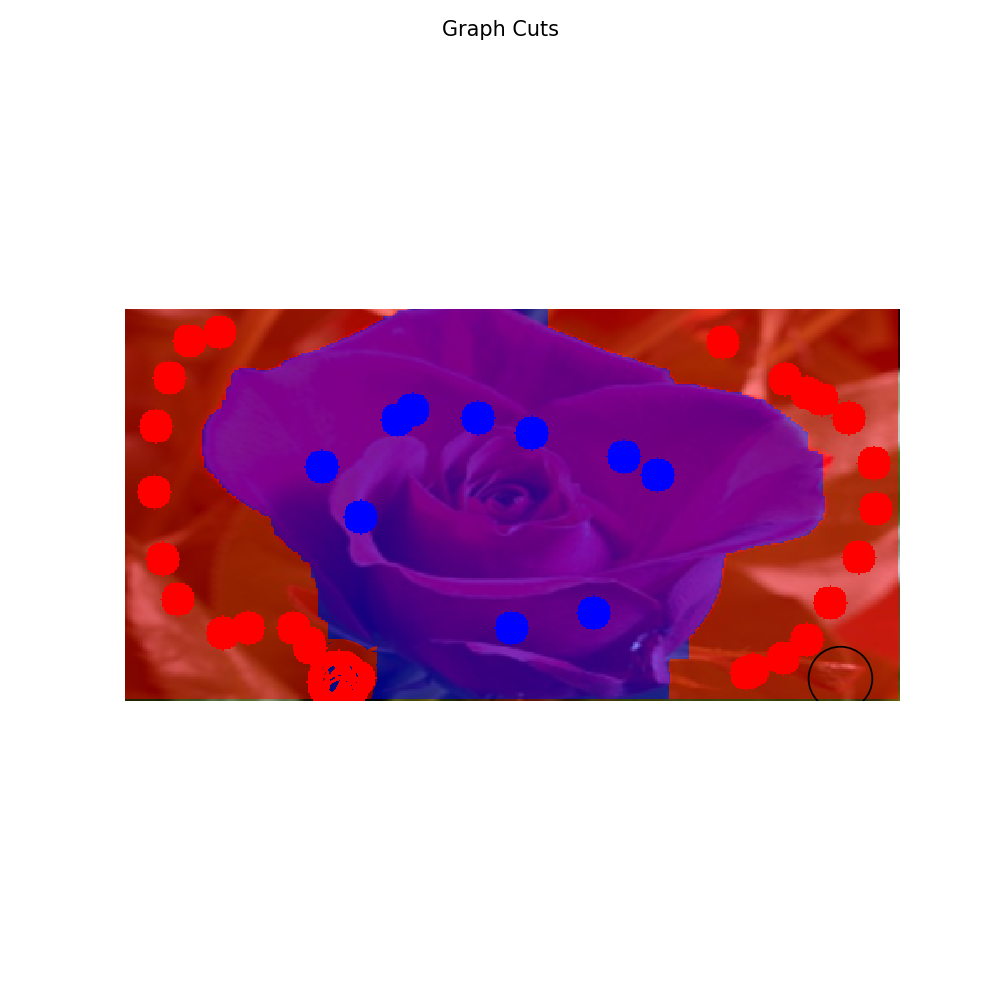

In [7]:
img = plt.imread('images/rose.bmp')
app = MyGraphCuts(img[10:300,:600])
app.run()


# Second milestone (using my own Kmeans function):
(My GraphCuts implementation is such that there will be segmentation only after at least 1 background and 1 object seed have been plotted)(Here we assume red area is background and blue area is object)

In [8]:
class MyKmeansApp:
    def __init__(self, img, num_clusters=2):
        self.k = num_clusters
        self.iteration = 0   # iteration counter
        self.energy = np.infty  # energy - "sum of squared errors" (SSE)

        num_rows = self.num_rows = img.shape[0]
        num_cols = self.num_cols = img.shape[1]

        self.im = img
        
        self.means = np.zeros((self.k,3),'d') # creates a zero-valued (double) matrix of size Kx5
        self.init_means()
      
        self.no_label = num_clusters  # special label value indicating pixels not in any cluster (e.g. not yet) 

        # mask "labels" where pixels of each "region" will have a unique index-label (like 0,1,2,3,..,K-1)
        # the default mask value is "no-label" (K) implying pixels that do not belong to any region (yet)
        self.labels = np.full((num_rows, num_cols), fill_value=self.no_label, dtype=np.int)
        
    def init_means(self):      
        self.iteration = 0           # resets iteration counter 
        self.energy = np.infty       # and the energy

        poolX = range(self.num_cols)
        poolY = range(self.num_rows)
        
        # generate K random pixels (Kx2 array with X,Y coordinates in each row)
        random_pixels = np.array([np.random.choice(poolX,self.k),np.random.choice(poolY,self.k)]).T
        
        for label in range(self.k):
            self.means[label,:3] = self.im[random_pixels[label,1],random_pixels[label,0],:3]
    
    # This function compute average values for R, G, B, X, Y channel (feature component) at pixels in each cluster
    # represented by labels in given mask "self.labels" storing indeces in range [0,K). The averages should be
    # saved in (Kx5) matrix "self.means". The return value should be the number of non-empty clusters. 
    def compute_means(self):
        labels = self.labels
        non_empty_clusters = 0
        
        tempRGBArray = np.reshape(RGBArray,(self.num_rows,self.num_cols,3))
        for label in range(self.k):
            clusterIndices = np.where(labels == label,True,False)
            if (len(clusterIndices) != 0):
                self.means[label,0] = np.average(tempRGBArray[clusterIndices,0])
                self.means[label,1] = np.average (tempRGBArray[clusterIndices,1])
                self.means[label,2] = np.average (tempRGBArray[clusterIndices,2])
                non_empty_clusters = non_empty_clusters + 1
            else:
                self.means[label,:] = np.infty
        
        return non_empty_clusters
            
    # The segmentation mask is used by KmeanPresenter to paint segments in distinct colors
    # NOTE: valid region labels are in [0,K), but the color map in KmeansPresenter
    #       accepts labels in range [0,K] where pixels with no_label=K are not painted/colored.
    def get_region_mask(self):  
        return self.labels  
    
    # This function computes optimal (cluster) index/label in range 0,1,...,K-1 for pixel x,y based on 
    # given current cluster means (self.means). The functions should save these labels in "self.labels".
    # The return value should be the corresponding optimal SSE.
    def compute_labels(self):
        global RGBArray
        shape = (self.num_rows,self.num_cols)
        opt_labels = np.full(shape, fill_value=self.no_label, dtype=np.int) # HINT: you can use this array to store and update
                                                                            # currently the best label for each pixel.
        
        min_dist = np.full(shape, fill_value=np.infty)  
        

        opt_labels = np.random.choice(range(self.k),shape)
        #min_dist = np.random.choice(range(100),shape)
        
        RGBArray = np.zeros((self.num_cols*self.num_rows,3),'d')
        RGBSSE = np.full((self.num_cols*self.num_rows), fill_value=np.inf)
        i = 0
        poolX = range(self.num_cols)
        poolY = range(self.num_rows)
        for r in poolY:
            for c in poolX:
                RGBArray[i,:3] = self.im[r,c,:3]
                i = i+1
        
        for label in range(self.k):
            RGBSSE = (RGBArray[:,0]-self.means[label,0])**2+(RGBArray[:,1]-self.means[label,1])**2 +(RGBArray[:,2]-self.means[label,2])**2
            RGBSSE = np.reshape(RGBSSE, (self.num_rows,self.num_cols)) 
            opt_labels = np.where(RGBSSE<min_dist, label, opt_labels)
            min_dist = np.where(RGBSSE<min_dist, RGBSSE, min_dist)

        
        # update the labels based on opt_labels computed above
        self.labels = opt_labels
        # returns the optimal SSE (corresponding to optimal clusters/labels for given means)
        return min_dist.sum()
         
    def getLabels(self):
        return self.labels
        
        
    # The function below is called by "on_key_down" in KmeansPresenter".
    # It's goal is to run an iteration of K-means procedure 
    # updating the means and the (segment) labels 
    def compute_k_means_clusters(self):  
        self.iteration += 1  

        # the main two steps of K-means algorithm
        energy = self.compute_labels()
        num_clusters = self.compute_means()

        # computing improvement and printing some information
        num_pixels = self.num_rows*self.num_cols
        improve_per_pixel = (self.energy - energy)/num_pixels
        energy_per_pixel = energy/num_pixels
        self.energy = energy
        return improve_per_pixel
    

In [19]:

class MyGraphCuts:
    bgr_value = 0
    obj_value = 1
    none_value = 2
    sigma = 0.1**2
    
    def __init__(self, img):
        self.fig = Figure()
        self.pres = GraphCutsPresenter(img, self)
        self.pres.connect_figure(self.fig)

        self.num_rows = img.shape[0]
        self.num_cols = img.shape[1]
        self.seedMask = np.zeros(shape=(img.shape[0],img.shape[1]))

    def run(self): 
        self.fig.show()
    
            
    def compute_labels(self, seed_mask):
        num_rows = self.num_rows
        num_cols = self.num_cols
        # +---------+---------+
        # |         |         |
        # |   bgr   |  none   |
        # |         |         |
        # +---------+---------+
        # |         |         |
        # |  none   |   obj   |
        # |         |         |
        # +---------+---------+
        
        label_mask = np.full((num_rows, num_cols), self.none_value, dtype='uint8')
        #label_mask[:num_rows // 2, :num_cols // 2] = self.bgr_value
        #label_mask[num_rows // 2:, num_cols // 2:] = self.obj_value
        g = maxflow.Graph[float]()
        nodeids = g.add_grid_nodes((num_rows, num_cols))

        weightsRight = np.zeros(shape=(num_rows, num_cols))
        weightsDown = np.zeros(shape=(num_rows, num_cols))
        normalisedImg = np.array((self.pres.img - np.min(self.pres.img)) / (np.max(self.pres.img) - np.min(self.pres.img)))
        image = self.pres.img
        row0,col0 = np.array(np.where(seed_mask==0)) # Seeded pixels are background
        row1,col1 = np.array(np.where(seed_mask==1)) # Seeded pixels are foreground
        
        ## Sigma is the related to level of variation in the image
        ## And it is set to the average absolute intensity difference between the neighboring pixels
        num_rows = image.shape[0]
        num_cols = image.shape[1]
        nodeids = g.add_grid_nodes((num_rows, num_cols))
        weightsRight = np.zeros(shape=(num_rows, num_cols), dtype= np.float64)
        weightsDown = np.zeros(shape=(num_rows, num_cols), dtype=np.float64)
        temp1 = np.zeros(shape=(num_rows* (num_cols-1) + (num_rows-1) * num_cols))
        temp2 = np.zeros(shape=((num_rows-1) * num_cols))
        eps = sys.float_info.epsilon
        j = 0
        for r in range(num_rows):
            for c in range (num_cols):
                if (c!=(num_cols-1)):
                    temp1[j] = np.abs(np.average(image[r,c])- np.average(image[r,c+1]))+eps
                    j+=1
                if (r!=(num_rows-1)):
                    temp1[j] = np.abs(np.average(image[r,c])- np.average(image[r+1,c]))+eps
                    j+=1
        variance = np.var(temp1, dtype=np.float64)
        
        for r in range (num_rows):
            for c in range(num_cols):
                if (c != (num_cols-1)):
                    temp = distance.sqeuclidean(image[r,c],image[r,c+1])
                    weightsRight[r,c] =np.exp(-temp/variance)
                                    
        for c in range (num_cols):
            for r in range (num_rows):
                if (r != (num_rows-1)):
                    temp = distance.sqeuclidean(image[r,c],image[r+1,c])
                    weightsDown[r,c] =np.exp(-temp/variance)
                                 
        
        weightsRight1D = np.reshape(weightsRight, (weightsRight.shape[0]*weightsRight.shape[1]))
        weightsDown1D =  np.reshape(weightsDown,(weightsDown.shape[0]*weightsDown.shape[1]))
        maxWeight = max(max(weightsRight1D), max(weightsDown1D))
        
        for r in range (num_rows):
            for c in range(num_cols):
                if (c in col0 and r in row0):
                    g.add_tedge(nodeids[r,c], 0, 3*maxWeight)
                elif (c in col1 and r in row1):
                    g.add_tedge(nodeids[r,c], 3*maxWeight,0)
                    
        structureRight = np.array([[0, 0, 0],
                          [0, 0, 1],
                          [0, 0, 0]])            
        g.add_grid_edges(nodeids, weights=weightsRight, structure=structureRight, symmetric=True)
        structureDown = np.array([[0, 0, 0],
                          [0, 0, 0],
                          [0, 1, 0]])
        g.add_grid_edges(nodeids, weights=weightsDown, structure=structureDown, symmetric=True)
        
        g.maxflow()
        seg = g.get_grid_segments(nodeids)
        
        #####################################################################################################################
        ### Colour Quantisation ###
        if (row0.size >0 and row1.size>0):
            img = self.pres.img
            bins = 5
            kMeans = MyKmeansApp(img, num_clusters=bins) ## Only take into account of RGB
            kMeans.compute_k_means_clusters()
            colourSeg = kMeans.getLabels()

            Pr0 = np.zeros(shape = bins)
            Pr0Bins = np.zeros(shape = (bins,2))
            Pr1 = np.zeros(shape = bins)
            for seg in range(bins):
                segPixelsRow, segPixelsCol = np.where(colourSeg == seg)
                bkg = 0 # Number of background colours
                frg = 0 # Number of object colours
                avgPixel = 0
                maxPixel = 0
                minPixel = 255
                for i in range(segPixelsRow.size):
                    if (segPixelsRow[i] in row0 and segPixelsCol[i] in col0): ## Background colour
                        bkg = bkg + 1
                    else: ## Foreground colour
                        frg = frg + 1
                Pr0[seg] = bkg

                Pr1[seg] = frg

            colourHistY0, colourHistX0 = np.histogram(Pr0,bins = bins, range = (0,255))
            colourHistY1, colourHistX1 = np.histogram(Pr1,bins = bins, range = (0,255))
            maxWeight = 0
            for r in range (num_rows):
                for c in range(num_cols):
                    if seed_mask[r,c] == 2:
                        newWeightsBkg = -np.log(colourHistY0[colourSeg[r,c]])
                        newWeightsFrg =-np.log(colourHistY1[colourSeg[r,c]])
                        g.add_tedge((r*num_cols)+c, newWeightsBkg, newWeightsFrg)
      
            g.maxflow()
            for r in range (self.num_rows-1):
                for c in range(self.num_cols-1):
                    label_mask[r][c] = g.get_segment((r*num_cols)+c)
            
        #################
        
        return label_mask

   

<IPython.core.display.Javascript object>


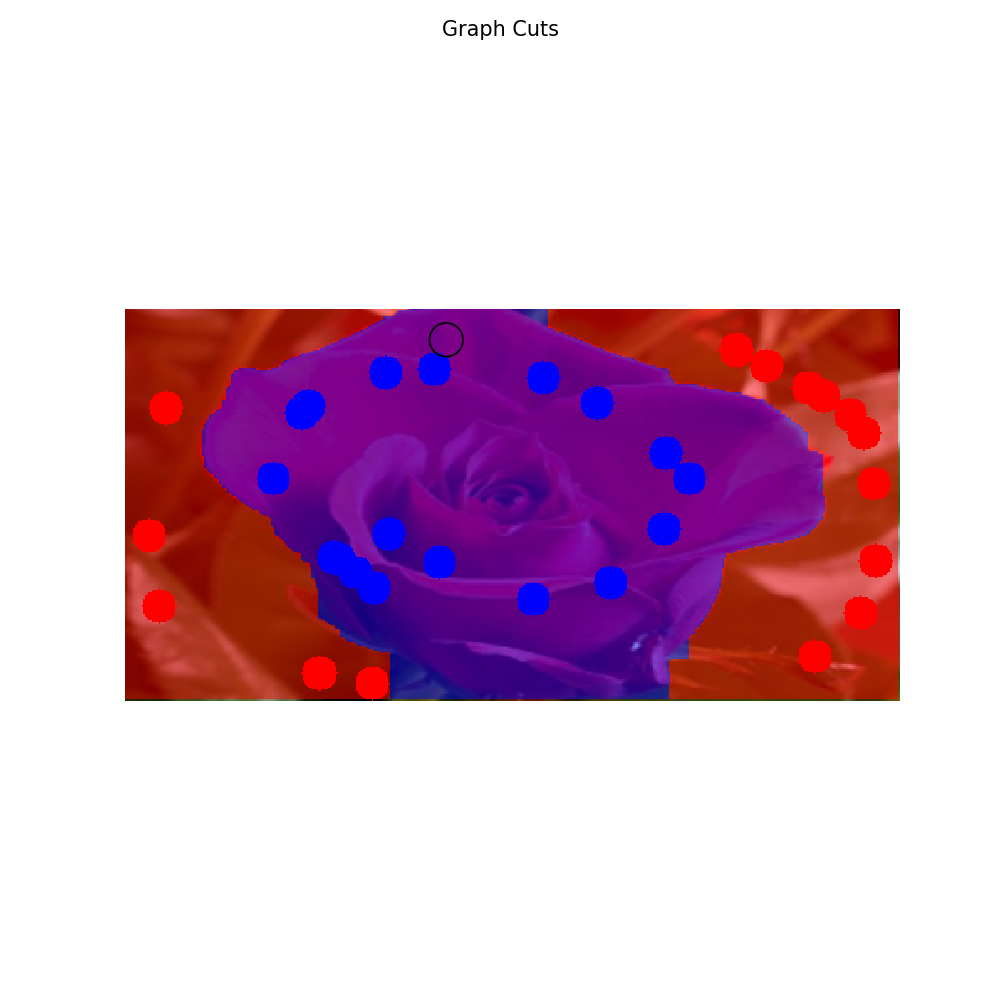

In [9]:
img = plt.imread('images/rose.bmp')
app = MyGraphCuts(img[10:300,:600])
app.run()
